In [44]:
import jax
import jax.numpy as jnp

import proplot as pplt
import numpy as np
import galsim

%matplotlib inline

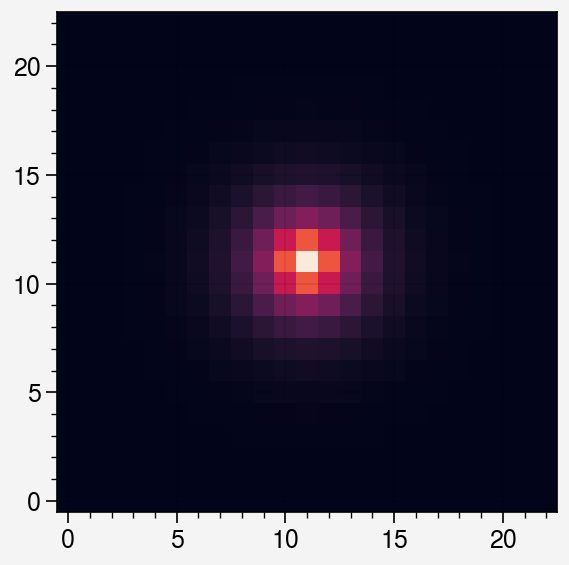

In [20]:
obj = galsim.Exponential(half_light_radius=0.5/0.2)
im = obj.drawImage(nx=23, ny=23, scale=1).array

fig, axs = pplt.subplots()
axs.imshow(im, origin="lower", cmap="rocket")

In [68]:
def _adaptive_shape_kern(im, sigma2):
    half = (23-1)//2
    y, x = jnp.mgrid[:23, :23]
    y = y - half
    x = x - half
    
    kern = jnp.exp(
        -0.5 * x * x / sigma2
        -0.5 * y * y / sigma2
    )
    
    norm = jnp.sum(im * kern)
    mx2 = jnp.sum(x * x * kern * im) / norm
    my2 = jnp.sum(y * y * kern * im) / norm

    
    # adaptive moments has this deweighting thing
    # I got this snippet out of ngmix
    idetm = 1.0 / (mx2 * my2)
    idetw = 1.0 / sigma2 / sigma2
    Nrr = mx2*idetm - sigma2*idetw  # Nrr = Icc*idetm - Wcc*idetw
    Ncc = my2*idetm - sigma2*idetw  # Ncc = Irr*idetm - Wrr*idetw
    detn = Nrr*Ncc

    # now set from the inverted matrix
    idetn = 1.0/detn
    mx2 = Ncc*idetn
    my2 = Nrr*idetn
    
    new_sigma2 = (mx2 + my2)/2.0
    
    return new_sigma2


def dumb_adaptive_thing(im):
    sigma2 = (2.0/0.2/2.355)**2
    for _ in range(10):
        sigma2 = _adaptive_shape_kern(im, sigma2)
    return sigma2

In [69]:
dumb_adaptive_thing(im)

Array(3.1479647, dtype=float32)

In [70]:
vg = jax.jit(jax.value_and_grad(dumb_adaptive_thing, 0))

In [73]:
%%time

sigma2, dsigma2_dimg = vg(im)

CPU times: user 3.35 ms, sys: 1.98 ms, total: 5.33 ms
Wall time: 4.01 ms


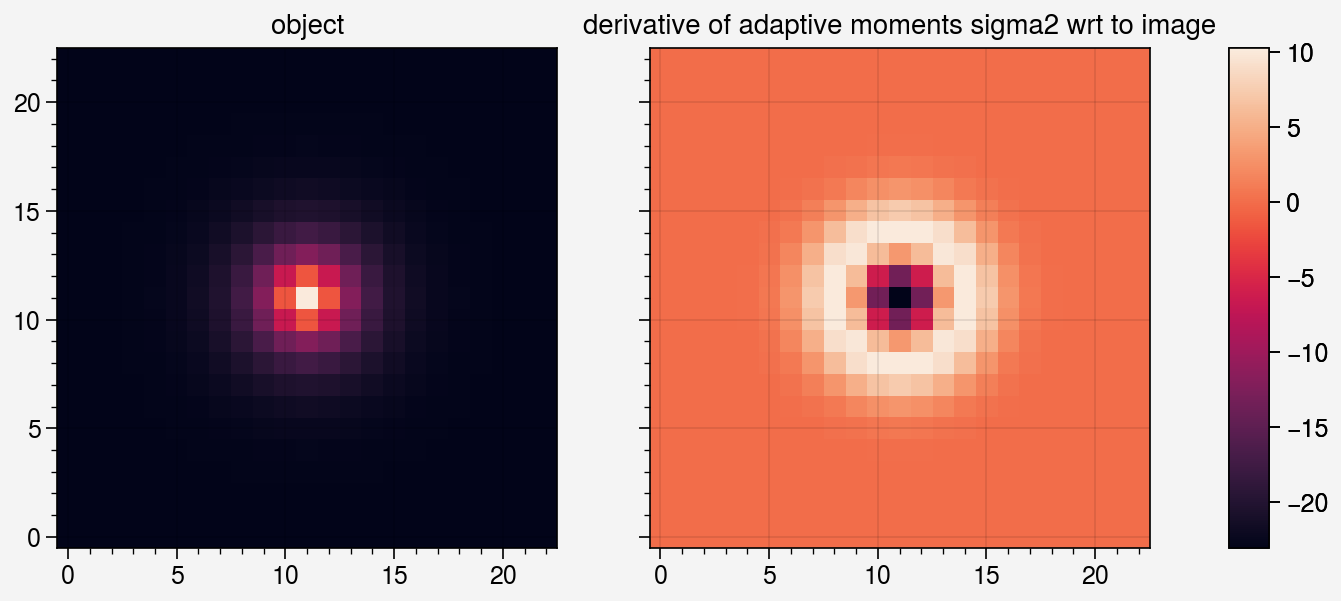

In [72]:
fig, axs = pplt.subplots(ncols=2, nrows=1)

axs[0].imshow(im, origin="lower", cmap="rocket")
axs[0].set_title("object")
m = axs[1].imshow(dsigma2_dimg, origin="lower", cmap="rocket")
axs[1].set_title("derivative of adaptive moments sigma2 wrt to image")
axs[1].colorbar(m, loc="r")